In [5]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

def split_xyz(input_file):
    # 获取源文件的文件夹路径和文件名
    folder_name = os.path.splitext(os.path.basename(input_file))[0]  # 去除扩展名
    folder_path = os.path.join(os.path.dirname(input_file), folder_name)  # 创建目标文件夹路径
    
    if os.path.exists(folder_path):
        # 文件夹已存在，先删除并清空
        shutil.rmtree(folder_path)
    
    # 文件夹不存在或已被清空，重新创建
    os.makedirs(folder_path)
    
    # 读取源文件内容
    with open(input_file, 'r') as f:
        lines = f.readlines()
    
    frame_count = 0
    i = 0
    while i < len(lines):
        # 读取每一帧的原子数
        num_atoms = int(lines[i].strip())
        
        # 读取当前帧的注释行
        frame_comment = lines[i + 1].strip()
        
        # 读取原子坐标
        atoms = lines[i + 2 : i + 2 + num_atoms]
        
        # 创建新文件并保存当前帧
        frame_count += 1
        output_filename = f"frame_{frame_count}.xyz"
        output_filepath = os.path.join(folder_path, output_filename)
        
        with open(output_filepath, 'w') as out_file:
            out_file.write(f"{num_atoms}\n")
            out_file.write(f"{frame_comment}\n")
            out_file.writelines(atoms)
        
        # 更新索引，跳过当前帧
        i += 2 + num_atoms
        print(f"Frame {frame_count} written to {output_filepath}")

    print("===xyz file splitting completed===\n")


def noe_calc(filename, natom, deleteH):


    # 计算距离
    def get_distance(filename):

        # 计算两点间的欧几里得距离
        def calculate_distance(atom1, atom2):
            return np.linalg.norm(atom1 - atom2)
        
        # 解析XYZ文件并提取原子坐标
        def parse_xyz(xyz_file):
            with open(xyz_file, 'r') as f:
                lines = f.readlines()
        
            num_atoms = int(lines[0].strip())  # 第一行是原子数
            coordinates = []
            
            for line in lines[2:2+num_atoms]:  # 从第三行开始是原子的元素和坐标
                parts = line.split()
                atom = parts[0]  # 元素符号
                x, y, z = map(float, parts[1:4])  # 坐标
                coordinates.append([x, y, z])
        
            return np.array(coordinates)  # 返回一个n x 3的数组，n为原子数
        
        # 计算原子距离矩阵
        def calculate_distance_matrix(coordinates):
            num_atoms = len(coordinates)
            distance_matrix = np.zeros((num_atoms, num_atoms))
        
            for i in range(num_atoms):
                for j in range(i + 1, num_atoms):
                    distance = calculate_distance(coordinates[i], coordinates[j])
                    distance_matrix[i][j] = distance_matrix[j][i] = distance  # 对称矩阵
        
            return distance_matrix
        
        xyz_file = f"{filename}.xyz"  # XYZ文件路径
        # output_file = xyz_file.replace(".xyz", "_distance_matrix.npy") #   # 输出的二进制矩阵文件路径
        print(f"Calculating distance matrix for {filename} ...")
        coordinates = parse_xyz(xyz_file)
        distance_matrix = calculate_distance_matrix(coordinates)
        return distance_matrix
    
    # 计算 1/r^6 矩阵
    def calculate_inverse_r6_matrix(distance_matrix, filename):
        # 避免除以零，先替换对角线上的值为np.inf
        np.fill_diagonal(distance_matrix, np.inf)
        print(f"Calculating 1/r^6 matrix for {filename} ...")
        inverse_r6_matrix = 1 / np.power(distance_matrix, 6)
        return inverse_r6_matrix
    
    # 计算平均值矩阵
    def calculate_avg_for_positions(inverse_r6_matrix, m, filename):
        print(f"Calculating molecular average 1/r^6 matrix for {filename} ...")
        n = inverse_r6_matrix.shape[0]
        
        # 新矩阵的尺寸应为 m x m
        avg_inverse_r6_matrix = np.zeros((m, m))
    
        # 计算每个位置的平均值
        for i in range(m):
            for j in range(m):
                # 对每个小块的位置 [i,j]，计算所有小块在这个位置的元素平均值
                values = []
                for row_block in range(n // m):
                    for col_block in range(n // m):
                        # 提取位置 [i, j] 对应的值
                        value = inverse_r6_matrix[row_block*m + i, col_block*m + j]
                        values.append(value)
                
                # 计算并赋值
                avg_inverse_r6_matrix[i, j] = np.mean(values)
        
        return avg_inverse_r6_matrix
    
    def modify_matrix(matrix, delete_list, filename):
        
        # 定义要删除的行和列的1-based索引
        rows_to_delete_1based = delete_list
        cols_to_delete_1based = delete_list
        
        # 将1-based索引转换为0-based索引
        rows_to_delete_0based = [index - 1 for index in rows_to_delete_1based]
        cols_to_delete_0based = [index - 1 for index in cols_to_delete_1based]
        
        # 删除指定的行和列
        matrix_modified = np.delete(matrix, rows_to_delete_0based, axis=0)  # 删除行
        matrix_modified = np.delete(matrix_modified, cols_to_delete_0based, axis=1)  # 删除列
        
        # 保存修改后的矩阵
        np.save(f"{filename}_avg_inverse_r6_matrix.npy", matrix_modified)
        print(f"Molecular average 1/r^6 matrix for {filename} saved in {filename}_avg_inverse_r6_matrix.npy:")
        print(matrix_modified)
    
    # main
    distance_matrix = get_distance(filename)
    inverse_r6_matrix = calculate_inverse_r6_matrix(distance_matrix, filename)
    m = natom  # 分子数
    avg_inverse_r6_matrix = calculate_avg_for_positions(inverse_r6_matrix, m, filename)
    delete_list = deleteH # 活泼氢 [21, 22, 23, 34, 35]
    modify_matrix(avg_inverse_r6_matrix, delete_list, filename)
    print(f"===Finish calculation for {filename}===\n")


def calculate_average_matrix(filename):
    print(f"Calculating time average 1/r^6 matrix for {filename} ...")
    # 获取当前目录下所有的 .npy 文件
    npy_files = [f for f in os.listdir() if f.endswith('.npy')]
    
    if len(npy_files) == 0:
        print("当前目录下没有 .npy 文件！")
        return

    # 加载第一个文件，假设所有矩阵大小相同
    first_matrix = np.load(npy_files[0])
    n = first_matrix.shape[0]  # 矩阵的大小 n*n
    sum_matrix = np.zeros_like(first_matrix, dtype=np.float64)  # 初始化一个零矩阵，用于累加

    # 遍历所有文件，逐个加载并累加矩阵
    for file in npy_files:
        matrix = np.load(file)
        sum_matrix += matrix  # 累加矩阵

    # 计算平均矩阵
    avg_matrix = sum_matrix / len(npy_files)

    # 保存到 time_avg_inverse_r6_matrix.npy 文件
    np.save(f"{filename}_time_avg_inverse_r6_matrix.npy", avg_matrix)
    print(f"Molecular average 1/r^6 matrix for {filename} saved in {filename}_time_avg_inverse_r6_matrix.npy:")
    print(avg_matrix)
    print(f"===Finish calculation for {filename}===\n")


def lorentzian_2d_broadening(X, Y, x_points, y_points, z_points, FWHM_x, FWHM_y):
    """
    计算二维洛伦兹展宽函数
    :param X: 目标网格的x坐标矩阵
    :param Y: 目标网格的y坐标矩阵
    :param x_points: 给定的x坐标点
    :param y_points: 给定的y坐标点
    :param z_points: 给定的z坐标点（对应x_points和y_points）
    :param FWHM_x: x方向的半高全宽
    :param FWHM_y: y方向的半高全宽
    :return: 展宽后的z值
    """
    Z = np.zeros_like(X)  # 初始化Z矩阵
    for i in range(len(x_points)):
        for j in range(len(y_points)):
            # 对每个(x, y)点进行展宽
            Z += z_points[i, j] * (FWHM_x / 2) / (np.pi * np.sqrt(((X - x_points[i])**2 + (FWHM_x / 2)**2) + ((Y - y_points[j])**2 + (FWHM_y / 2)**2)))
    return Z

    
if __name__ == "__main__":
    # 只有在直接运行该脚本时，才执行以下测试代码
    print("Testing utility functions")
    

Testing utility functions


In [6]:
import time
start_time = time.time()

# 使用函数来拆分文件
filename = "aza_H_traj"
input_xyz_file = f"{filename}.xyz"
split_xyz(input_xyz_file)

# 进入保存独立xyz文件的子目录
current_directory = os.getcwd()
folder_name = filename  # 替换为你要进入的文件夹名
folder_path = os.path.join(current_directory, folder_name)
os.chdir(folder_path) # 切换到目标文件夹

# 遍历xyz文件
current_directory = os.getcwd()
xyz_files = [f for f in os.listdir(current_directory) if f.endswith('.xyz')] 
for xyz_file in xyz_files:
    natom = 58
    deleteH = [21,22,23,34,35]
    noe_calc(xyz_file.split('.', 1)[0], natom, deleteH)

calculate_average_matrix(filename)

os.chdir('..')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.4f} seconds")

Frame 1 written to aza_H_traj\frame_1.xyz
Frame 2 written to aza_H_traj\frame_2.xyz
Frame 3 written to aza_H_traj\frame_3.xyz
Frame 4 written to aza_H_traj\frame_4.xyz
Frame 5 written to aza_H_traj\frame_5.xyz
Frame 6 written to aza_H_traj\frame_6.xyz
Frame 7 written to aza_H_traj\frame_7.xyz
Frame 8 written to aza_H_traj\frame_8.xyz
Frame 9 written to aza_H_traj\frame_9.xyz
Frame 10 written to aza_H_traj\frame_10.xyz
Frame 11 written to aza_H_traj\frame_11.xyz
Frame 12 written to aza_H_traj\frame_12.xyz
Frame 13 written to aza_H_traj\frame_13.xyz
Frame 14 written to aza_H_traj\frame_14.xyz
Frame 15 written to aza_H_traj\frame_15.xyz
Frame 16 written to aza_H_traj\frame_16.xyz
Frame 17 written to aza_H_traj\frame_17.xyz
Frame 18 written to aza_H_traj\frame_18.xyz
===xyz file splitting completed===

Calculating distance matrix for frame_1 ...
Calculating 1/r^6 matrix for frame_1 ...
Calculating molecular average 1/r^6 matrix for frame_1 ...
Molecular average 1/r^6 matrix for frame_1 sav

[2.6  2.6  1.72 1.72 2.6  2.6  2.77 2.77 2.46 2.46 2.46 2.46 1.72 1.72
 2.6  2.6  2.77 2.77 2.77 2.77 2.77 2.77 1.38 1.38 1.23 1.23 1.23 1.23
 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23
 1.23 1.23 1.23 1.23 1.23 1.23 1.23 1.23 0.82 0.82 0.82]


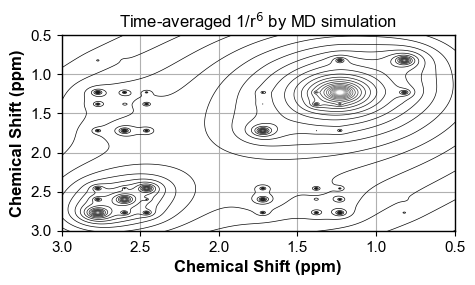

In [28]:

# 参数设置
x_points = np.array([2.6, 2.6, 1.72, 1.72, 2.6, 2.6, 2.77, 2.77, 2.46, 2.46, 2.46, 2.46, 1.72, 1.72, 2.6, 2.6, 2.77, 2.77, 2.77, 2.77, 2.77, 2.77, 1.38, 1.38, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 1.23, 0.82, 0.82, 0.82])   # 给定的x坐标
y_points = x_points
print(y_points)
z_points = np.load('aza_H_traj/aza_H_traj_time_avg_inverse_r6_matrix.npy')
FWHM_x, FWHM_y = 0.005, 0.005  # x和y方向的半高全宽

# 目标网格（可以细化）
x_fine = np.linspace(0.0010067, 4.99899, 861) # x_fine = np.linspace(0, 6, 300)
y_fine = np.linspace(0.0010067, 4.99899, 861)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

# 计算展宽后的z值
# Z_fine = lorentzian_2d_broadening(X_fine, Y_fine, x_points, y_points, z_points, FWHM_x, FWHM_y)
# np.save("aza_H_traj_time_avg_inverse_r6_matrix_fine.npy", Z_fine)
Z_fine = np.load('aza_H_traj_time_avg_inverse_r6_matrix_fine.npy')

# 绘制等高线图
plt.figure(figsize=(6.44/2.54*2, 6.44/2.54)) # 6.44
# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial' 
# 设置图形边框线宽
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)  # 设置所有边框的线宽为 1
    
vmax=np.max(Z_fine) * 0.3
vmin=np.max(Z_fine) * 0.001
levels = np.logspace(np.log10(vmin), np.log10(vmax), 40)
plt.contour(X_fine, Y_fine, Z_fine, levels, cmap='Greys_r', linewidths=0.5) # inferno, Greys_r
""" 
    'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 
    'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 
    'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 
    'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 
    'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 
    'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 
    'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 
    'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
    'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 
    'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 
    'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 
    'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 
    'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 
    'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 
    'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 
    'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 
    'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 
    'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 
    'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
"""
plt.xlim(0.5, 3.0)  # 设置 X 轴范围
plt.ylim(0.5, 3.0)   # 设置 Y 轴范围
plt.gca().invert_xaxis()  # 反转 X 轴
plt.gca().invert_yaxis()  # 反转 Y 轴
plt.tick_params(axis='both', which='major', labelsize=11)
# cbar = plt.colorbar()  # 显示颜色条
# cbar.set_label('d$^-^6$ (Å$^-^6$)', fontsize=10) # 设置颜色条的标题
plt.title('Time-averaged 1/r$^6$ by MD simulation')
plt.xlabel('Chemical Shift (ppm)', fontsize=12, fontweight='semibold')
plt.ylabel('Chemical Shift (ppm)', fontsize=12, fontweight='semibold')
plt.grid(True)
plt.savefig('AZA_H_time_avg.png', dpi=600, bbox_inches='tight')
plt.show()


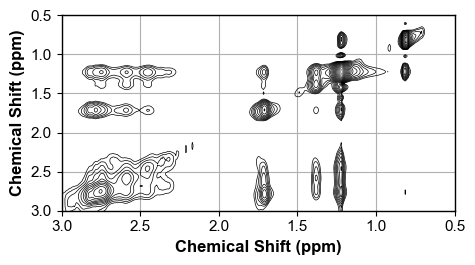

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件，第一列为y，第一行是x，剩余部分是z值
df = pd.read_csv('EXP_NOE_DATA.csv', index_col=0)

# 将 DataFrame 转换为 numpy 数组
Z = df.values       # 获取 z 值矩阵
# x = df.columns.to_numpy()  # 第一行是 x 的值
# y = df.index.to_numpy()    # 第一列是 y 的值

# 创建网格
x = np.linspace(0.0010067, 4.99899, 861)
y = np.linspace(0.0010067, 4.99899, 861)
X, Y = np.meshgrid(x, y)  # np.arange(Z.shape[0])

plt.figure(figsize=(6.44/2.54*2, 6.44/2.54)) # 6.44
# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial' 
# 设置图形边框线宽
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)  # 设置所有边框的线宽为 1

# 绘制等高线图2
vmax=np.max(Z)
vmin=vmax * 0.0005
levels = np.logspace(np.log10(vmin), np.log10(vmax), 20)
contour2 = plt.contour(X, Y, Z, levels, cmap='Greys_r', linewidths=0.5)

# 设置 X 和 Y 轴的范围
plt.xlim(0.5, 3.0)  # 设置 X 轴范围
plt.ylim(0.5, 3.0)   # 设置 Y 轴范围

# 反转 X 和 Y 轴
plt.gca().invert_xaxis()  # 反转 X 轴
plt.gca().invert_yaxis()  # 反转 Y 轴

plt.tick_params(axis='both', which='major', labelsize=11)

# plt.colorbar()  # 显示颜色条
# plt.title('NOESY')
plt.xlabel('Chemical Shift (ppm)', fontsize=12, fontweight='semibold')
plt.ylabel('Chemical Shift (ppm)', fontsize=12, fontweight='semibold')
plt.grid(True)
plt.savefig('exp_NOE_2.png', dpi=600, bbox_inches='tight')

plt.show()

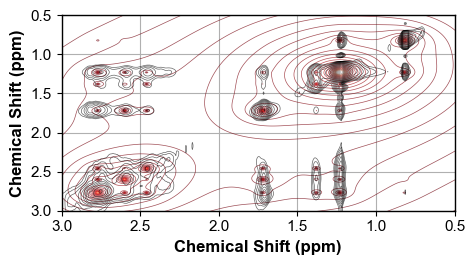

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件，第一列为y，第一行是x，剩余部分是z值
df = pd.read_csv('EXP_NOE_DATA.csv', index_col=0)

# 将 DataFrame 转换为 numpy 数组
Z = df.values       # 获取 z 值矩阵
# x = df.columns.to_numpy()  # 第一行是 x 的值
# y = df.index.to_numpy()    # 第一列是 y 的值

# 创建网格
x = np.linspace(0.0010067, 4.99899, 861)
y = np.linspace(0.0010067, 4.99899, 861)
X, Y = np.meshgrid(x, y)  # np.arange(Z.shape[0])

plt.figure(figsize=(6.44/2.54*2, 6.44/2.54)) # 6.44
# 设置全局字体为 Arial
plt.rcParams['font.family'] = 'Arial' 
# 设置图形边框线宽
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1)  # 设置所有边框的线宽为 1

Z_fine = np.load('aza_H_traj_time_avg_inverse_r6_matrix_fine.npy')
vmax=np.max(Z_fine) * 0.3
vmin=np.max(Z_fine) * 0.001
levels = np.logspace(np.log10(vmin), np.log10(vmax), 40)
contour1 = plt.contour(X, Y, Z_fine, levels, cmap='Reds_r', linewidths=0.5, alpha=0.7)
# 绘制等高线图2
vmax=np.max(Z)
vmin=vmax * 0.0005
levels = np.logspace(np.log10(vmin), np.log10(vmax), 20)
contour2 = plt.contour(X, Y, Z, levels, cmap='Greys_r', linewidths=0.5, alpha=0.6)

# 设置 X 和 Y 轴的范围
plt.xlim(0.5, 3.0)  # 设置 X 轴范围
plt.ylim(0.5, 3.0)   # 设置 Y 轴范围

# 反转 X 和 Y 轴
plt.gca().invert_xaxis()  # 反转 X 轴
plt.gca().invert_yaxis()  # 反转 Y 轴

plt.tick_params(axis='both', which='major', labelsize=11)

# plt.colorbar()  # 显示颜色条
# plt.title('Contour plot')
plt.xlabel('Chemical Shift (ppm)', fontsize=12, fontweight='semibold')
plt.ylabel('Chemical Shift (ppm)', fontsize=12, fontweight='semibold')
plt.grid(True)
plt.savefig('expNOE_drSim.tif', dpi=600, bbox_inches='tight')

plt.show()


In [6]:
os.chdir('..')
current_directory = os.getcwd()
print(f"当前目录: {current_directory}")

当前目录: E:\BaiduSyncdisk\others\gauss\aza_crown\MD\bind\noe


In [7]:
import os
os.chdir('pop')

In [8]:
current_directory = os.getcwd()
print(f"当前目录: {current_directory}")

当前目录: E:\BaiduSyncdisk\others\gauss\aza_crown\MD\bind\noe\pop
